In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

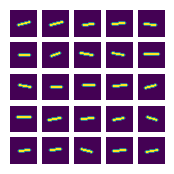

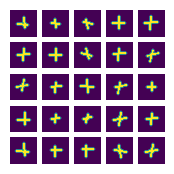

In [3]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [4]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #6744

X_text: "33+72" = y_text: "105"


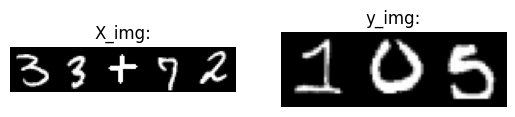

Query #4686

X_text: "23+43" = y_text: "66 "


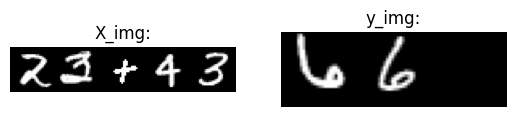

Query #788

X_text: "3+94 " = y_text: "97 "


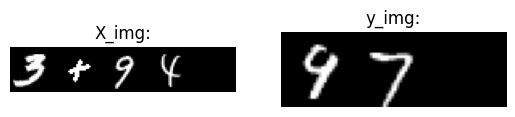

Query #1154

X_text: "5+77 " = y_text: "82 "


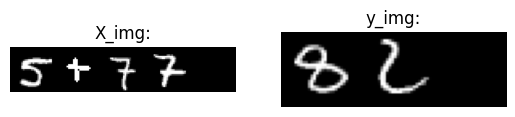

Query #4722

X_text: "23+61" = y_text: "84 "


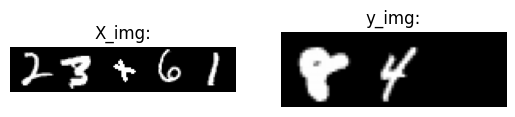

Query #6657

X_text: "33-28" = y_text: "5  "


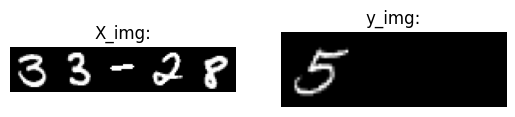

Query #5460

X_text: "27+30" = y_text: "57 "


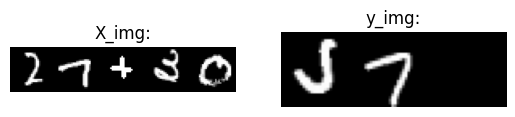

Query #6343

X_text: "31-71" = y_text: "-40"


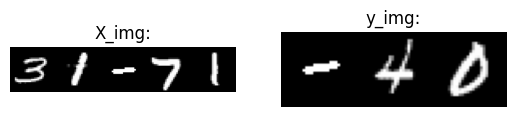

Query #2386

X_text: "11+93" = y_text: "104"


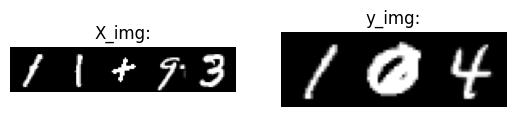

Query #2598

X_text: "12+99" = y_text: "111"


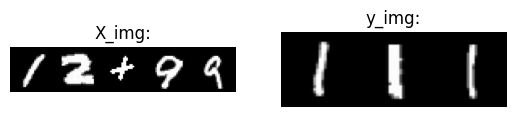

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [6]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


## Text to Text model

In [7]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

W0000 00:00:1733406135.107174  116314 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/vol/home/s4201388/Documents/Leiden/IDL/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.3087 - loss: 2.1060 - val_accuracy: 0.3803 - val_loss: 1.7707
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4382 - loss: 1.5709 - val_accuracy: 0.5139 - val_loss: 1.3658
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5117 - loss: 1.3430 - val_accuracy: 0.5578 - val_loss: 1.2127
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5560 - loss: 1.2195 - val_accuracy: 0.5913 - val_loss: 1.1582
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5788 - loss: 1.1597 - val_accuracy: 0.6029 - val_loss: 1.0799
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6039 - loss: 1.0883 - val_accuracy: 0.6113 - val_loss: 1.0543
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6204 - loss: 1.0384 - val_accuracy: 0.6181 - val_loss: 1.0182
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6282 - loss: 1.0131 - val_accu

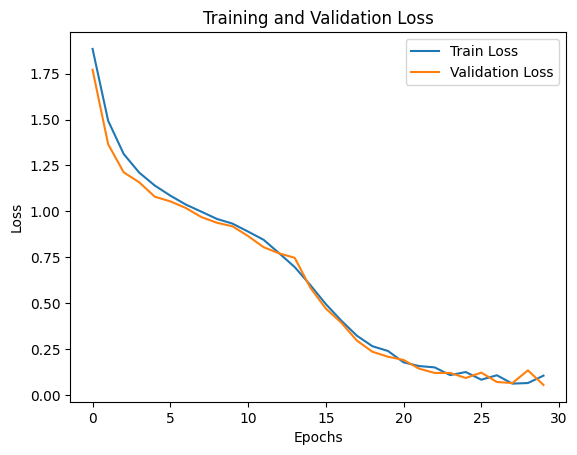

In [7]:
# Build the model
text2text_model = build_text2text_model()

# One-hot encode the labels for training
X_text_onehot = encode_labels(X_text, max_len=max_query_length)
y_text_onehot = encode_labels(y_text, max_len=max_answer_length)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.2, random_state=42
)

# Add Early Stopping to monitor validation loss
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = text2text_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,        # Maximum number of epochs to train
    batch_size=64,    # Batch size for training
    callbacks=[early_stop]
)

# Plot the training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


I tested this model (below) for image to text but the predictions wasnt right so I try changing the batch and learnign rate and others 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 5, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 28, 28, 64)     │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 50176)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │    51,643,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,797,005 (197.59 MB)

 Trainable params: 51,796,877 (197.59 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 746ms/step - accuracy: 0.2791 - loss: 2.3002 - val_accuracy: 0.1548 - val_loss: 2.4509 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.4034 - loss: 1.8074 - val_accuracy: 0.3198 - val_loss: 2.3490 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.4361 - loss: 1.6438 - val_accuracy: 0.2999 - val_loss: 2.5489 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.4835 - loss: 1.4962 - val_accuracy: 0.2707 - val_loss: 2.5344 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 231s 925ms/step - accuracy: 0.5522 - loss: 1.3175 - val_accuracy: 0.2837 - val_loss: 2.5832 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6368 - loss: 1.0983 - val_accuracy: 0.3031 - val_loss: 2.7083 - learning_rate: 5.0000e-04
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7072 

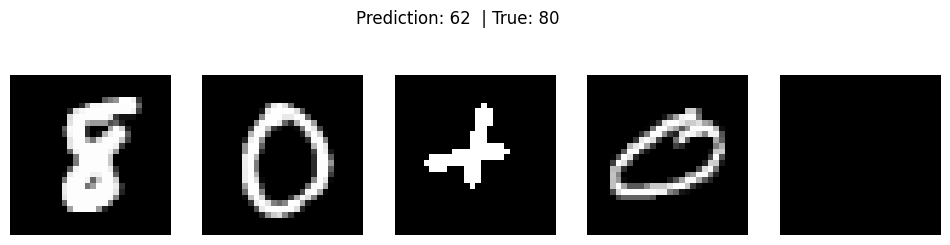

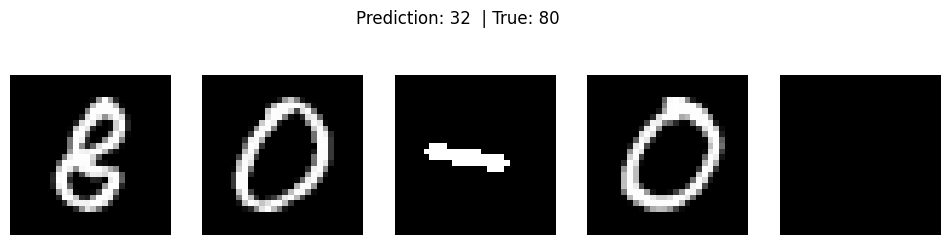

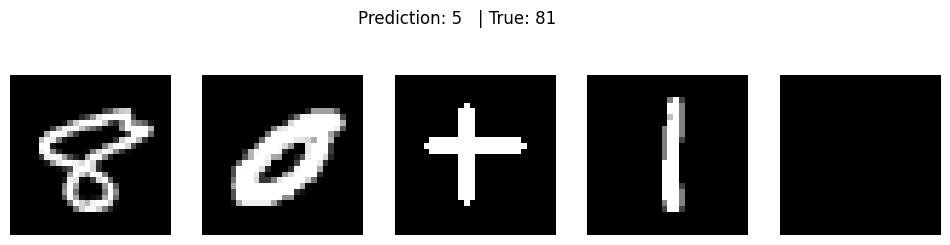

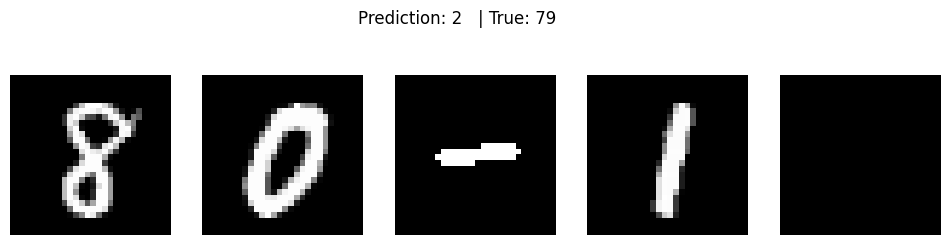

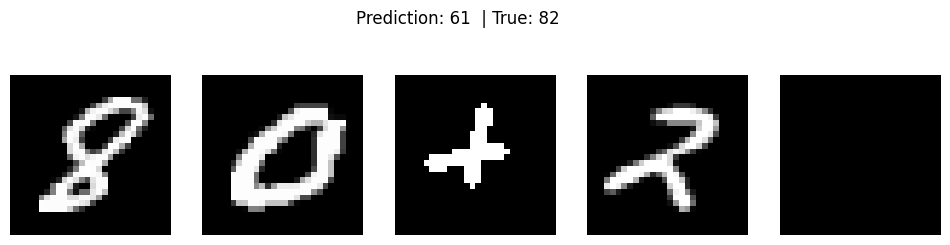

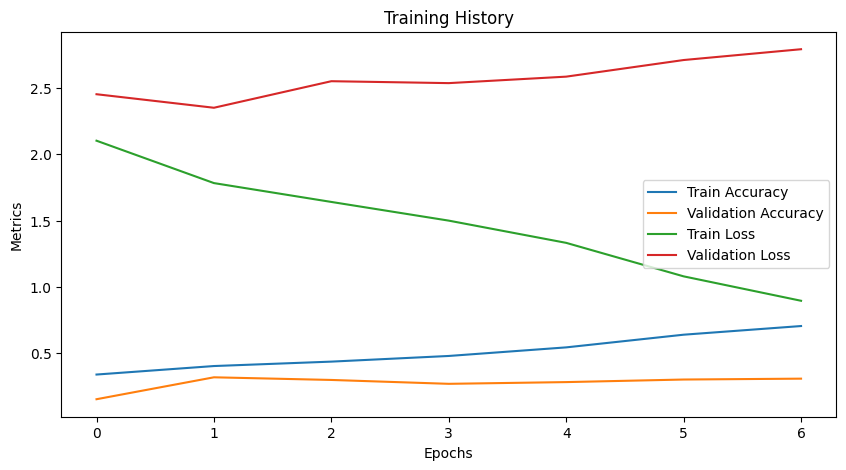

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, Flatten, Dense, RepeatVector, LSTM, TimeDistributed, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define global variables for the data generation
unique_characters = "0123456789+- "
highest_integer = 99
max_query_length = 5  # Input sequence length (e.g., '89+56')
max_answer_length = 3  # Output sequence length (e.g., '145')

# Data preparation function (from your teacher)
def create_dataset():
    (MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
    X_text, X_img, y_text, y_img = create_data(highest_integer)
    return X_text, X_img, y_text, y_img

# One-hot encoding function (from your teacher)
def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        for j, char in enumerate(label):
            one_hot[i, j, char_map[char]] = 1
    return one_hot
def decode_labels(labels, unique_characters):
    """
    Decodes one-hot encoded labels into their original string representation.
    """
    idx_to_char = {idx: char for idx, char in enumerate(unique_characters)}
    decoded = [''.join([idx_to_char[np.argmax(char)] for char in seq]) for seq in labels]
    return decoded

# Model building function
def build_image2text_model(input_shape, vocab_size, max_answer_len):
    inputs = Input(shape=input_shape, name="image_input")
    x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = RepeatVector(max_answer_len)(x)
    x = LSTM(256, return_sequences=True, activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = TimeDistributed(Dense(vocab_size, activation="softmax"))(x)
    return Model(inputs, outputs=x)

# Load and preprocess the dataset
X_text, X_img, y_text, y_img = create_dataset()
X_text_onehot = encode_labels(X_text, max_query_length)
y_text_onehot = encode_labels(y_text, max_answer_length)

# Split the dataset into training and testing sets
split_index = int(0.8 * len(X_img))
X_train, X_test = X_img[:split_index], X_img[split_index:]
y_train, y_test = y_text_onehot[:split_index], y_text_onehot[split_index:]

# Reshape input data for the model
X_train = X_train[..., np.newaxis]  # Add a channel dimension (grayscale images)
X_test = X_test[..., np.newaxis]

# Build the model
input_shape = (max_query_length, 28, 28, 1)
vocab_size = len(unique_characters)
max_answer_len = max_answer_length

model = build_image2text_model(input_shape, vocab_size, max_answer_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train the model
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)

# Evaluate the model
predictions = model.predict(X_test)
decoded_predictions = decode_labels(predictions, unique_characters)
decoded_ground_truths = decode_labels(y_test, unique_characters)

# Display a few test samples with predictions
for i in range(5):
    plt.figure(figsize=(12, 3))
    for j in range(max_query_length):
        plt.subplot(1, max_query_length, j + 1)
        plt.imshow(X_test[i, j, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Prediction: {decoded_predictions[i]} | True: {decoded_ground_truths[i]}")
    plt.show()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()


## Image to text Model ( main answer
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 5, 28, 28, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 28, 28,    │    594,944 │ image_input[0][0] │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv_lstm2d_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 100352)    │          0 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 3, 100352) │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 3, 256)    │ 103,023,6… │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 3, 256)    │          0 │ lstm_2[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 512)    │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 3, 128)    │     65,664 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 3, 13)     │      1,677 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,686,413 (395.53 MB)

 Trainable params: 103,686,157 (395.53 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1436s 12s/step - accuracy: 0.2819 - loss: 2.2742 - val_accuracy: 0.0557 - val_loss: 2.6100 - learning_rate: 5.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1332s 11s/step - accuracy: 0.4023 - loss: 1.7924 - val_accuracy: 0.2012 - val_loss: 2.5429 - learning_rate: 5.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 729s 6s/step - accuracy: 0.4514 - loss: 1.6066 - val_accuracy: 0.3583 - val_loss: 2.2045 - learning_rate: 5.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1121s 9s/step - accuracy: 0.5261 - loss: 1.4087 - val_accuracy: 0.3700 - val_loss: 2.3328 - learning_rate: 5.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 722s 6s/step - accuracy: 0.6269 - loss: 1.1415 - val_accuracy: 0.3079 - val_loss: 2.7876 - learning_rate: 5.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1073s 9s/step - accuracy: 0.7424 - loss: 0.8101 - val_accuracy: 0.2973 - val_loss: 3.0558 - learning_rate: 5.0000e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 690s 6s/step

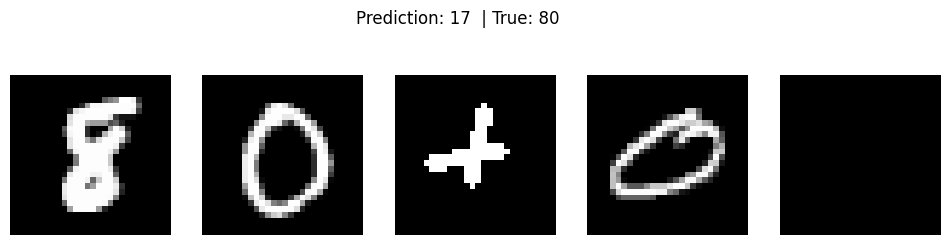

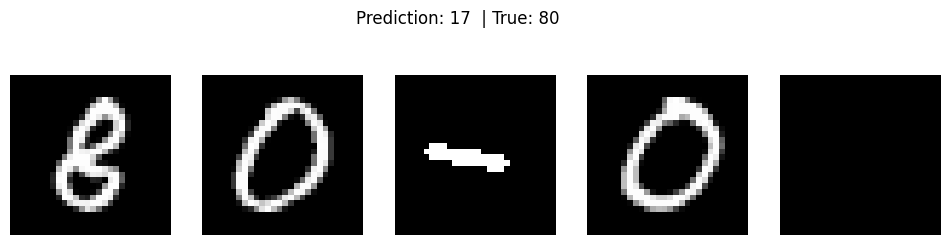

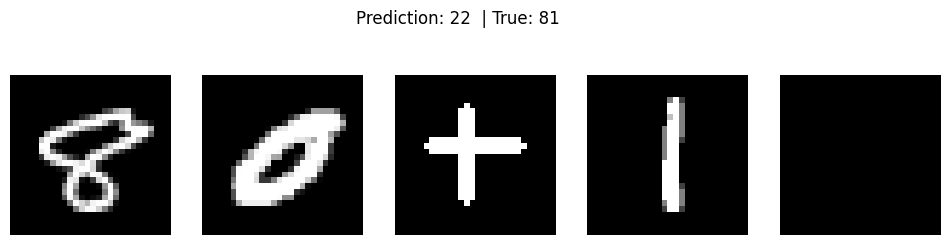

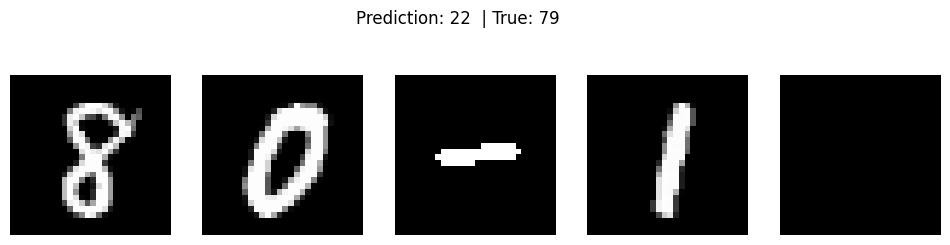

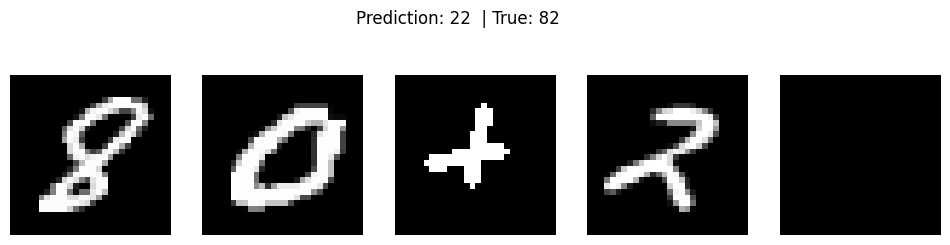

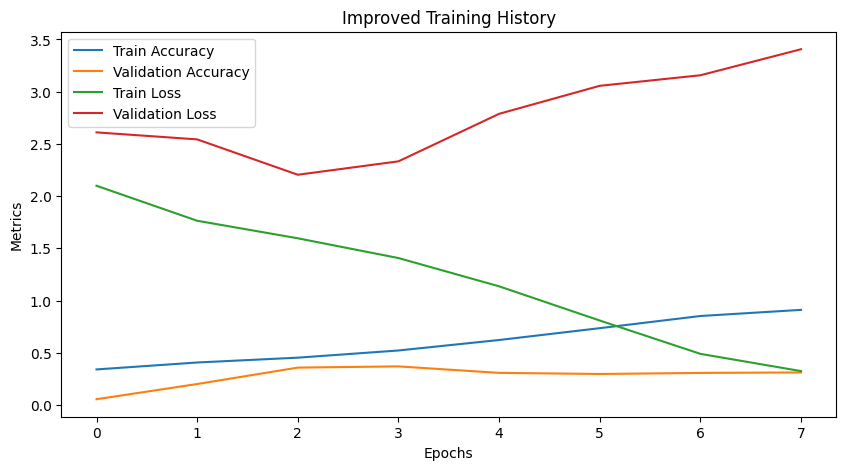

In [14]:
from tensorflow.keras.layers import Attention

def build_improved_image2text_model(input_shape, vocab_size, max_answer_len):
    inputs = Input(shape=input_shape, name="image_input")
    
    # Encoder: Improved feature extraction with ConvLSTM2D
    x = ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    
    # Decoder: Added attention mechanism
    x = RepeatVector(max_answer_len)(x)
    decoder_lstm = LSTM(256, return_sequences=True, activation="tanh")
    x = decoder_lstm(x)
    
    # Attention Layer
    attention = Attention()([x, x])
    x = tf.keras.layers.Concatenate(axis=-1)([x, attention])  # Combine LSTM output and attention
    
    # Final TimeDistributed Dense layer for output
    x = TimeDistributed(Dense(128, activation="relu"))(x)
    outputs = TimeDistributed(Dense(vocab_size, activation="softmax"))(x)
    
    return Model(inputs, outputs=outputs)

# Build the improved model
improved_model = build_improved_image2text_model(input_shape, vocab_size, max_answer_len)
improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Smaller learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
improved_model.summary()

# Train the improved model
history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Increase epochs for better learning
    batch_size=128,  # Larger batch size
    callbacks=callbacks
)

# Evaluate the improved model
predictions = improved_model.predict(X_test)
decoded_predictions = decode_labels(predictions, unique_characters)
decoded_ground_truths = decode_labels(y_test, unique_characters)

# Display results for comparison
for i in range(5):
    plt.figure(figsize=(12, 3))
    for j in range(max_query_length):
        plt.subplot(1, max_query_length, j + 1)
        plt.imshow(X_test[i, j, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Prediction: {decoded_predictions[i]} | True: {decoded_ground_truths[i]}")
    plt.show()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Improved Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()


THis was test models and are not my answers but maybe you can get in idea from it and improve the main model and if not just remove it 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 5, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 28, 28, 64)     │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 3, 50176)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 3, 256)         │    51,643,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 3, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_output (TimeDistributed)   │ (None, 3, 13)          │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,999,885 (198.36 MB)

 Trainable params: 51,999,757 (198.36 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.2591 - loss: 2.2513 - val_accuracy: 0.0678 - val_loss: 2.6347 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.3931 - loss: 1.8660 - val_accuracy: 0.2133 - val_loss: 2.5193 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.4045 - loss: 1.7199 - val_accuracy: 0.3545 - val_loss: 2.1293 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 462s 4s/step - accuracy: 0.4219 - loss: 1.6366 - val_accuracy: 0.3498 - val_loss: 2.0640 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.4376 - loss: 1.5628 - val_accuracy: 0.3314 - val_loss: 2.3061 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - accuracy: 0.4506 - loss: 1.5101 - val_accuracy: 0.2924 - val_loss: 2.7851 - learning_rate: 0.0010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.4643 - loss: 1.

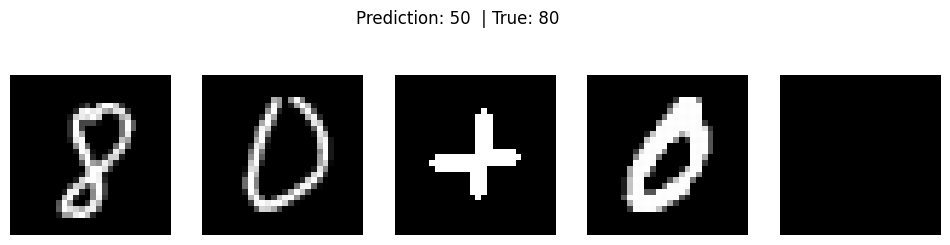

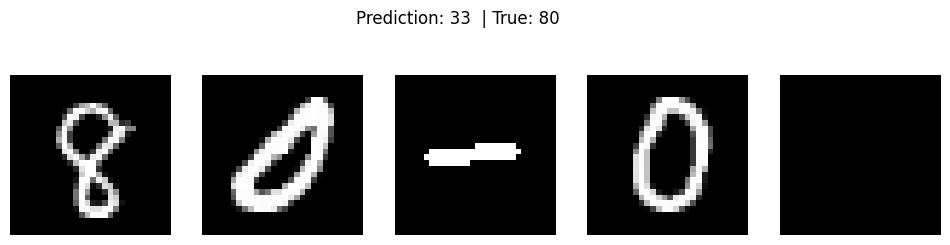

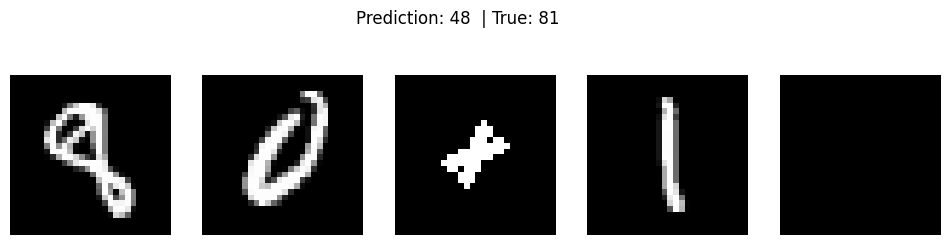

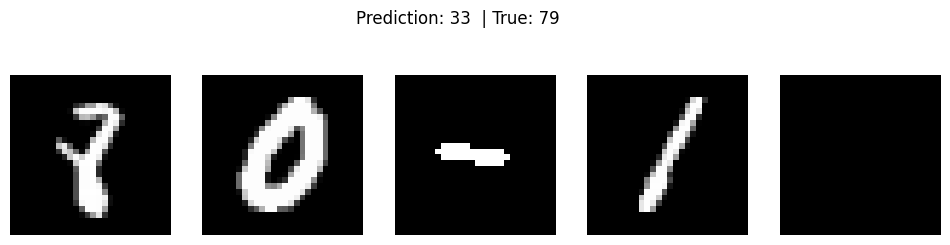

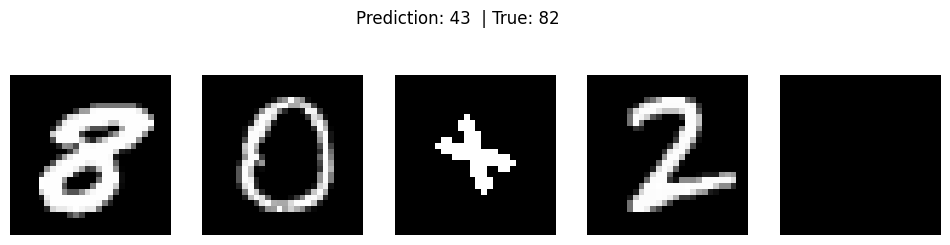

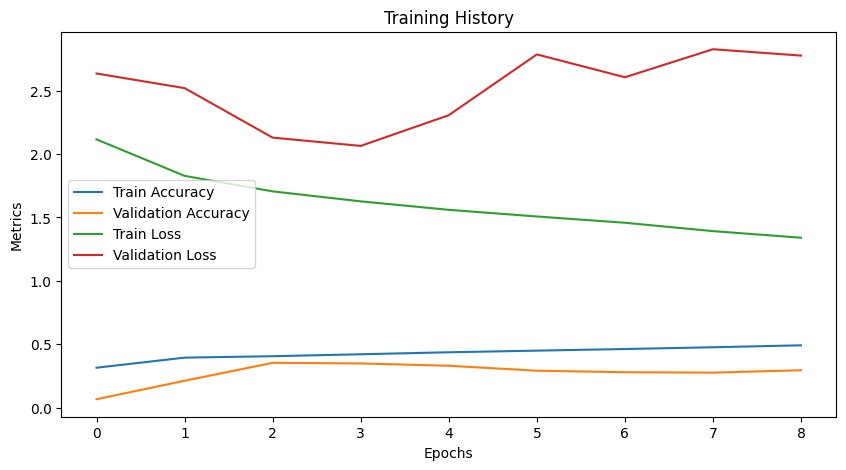

In [38]:
from tensorflow.keras.layers import Input, ConvLSTM2D, Flatten, Dense, RepeatVector, LSTM, TimeDistributed, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parameters
unique_characters = "0123456789+- "
vocab_size = len(unique_characters)
max_query_len = 5  # Input sequence length (e.g., '89+56')
max_answer_len = 3  # Output sequence length (e.g., '145')
input_shape = (max_query_len, 28, 28, 1)

# Helper Functions
def encode_labels(labels, max_len, vocab):
    char_to_idx = {char: idx for idx, char in enumerate(vocab)}
    one_hot = np.zeros((len(labels), max_len, len(vocab)))
    for i, seq in enumerate(labels):
        for j, char in enumerate(seq):
            one_hot[i, j, char_to_idx[char]] = 1.0
    return one_hot

def decode_labels(predictions, vocab):
    idx_to_char = {idx: char for idx, char in enumerate(vocab)}
    decoded = []
    for pred in predictions:
        decoded.append("".join([idx_to_char[np.argmax(char)] for char in pred]))
    return decoded

# Build Model
def build_image_to_text_model(input_shape, vocab_size, max_answer_len):
    inputs = Input(shape=input_shape, name="image_input")
    
    # Encoder: ConvLSTM2D for extracting spatial-temporal features
    x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    
    # Decoder: RepeatVector to prepare for sequence generation
    x = RepeatVector(max_answer_len)(x)
    x = LSTM(256, return_sequences=True, activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = LSTM(128, return_sequences=True, activation="tanh")(x)
    x = Dropout(0.4)(x)
    
    # Add a Dense layer for improved representation
    x = TimeDistributed(Dense(64, activation="relu"))(x)
    outputs = TimeDistributed(Dense(vocab_size, activation="softmax"), name="text_output")(x)
    
    return Model(inputs, outputs)

# Data Preparation
def create_dataset():
    # Use provided data generation code
    highest_integer = 99
    (MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
    X_text, X_img, y_text, y_img = create_data(highest_integer)
    X_text_onehot = encode_labels(X_text, max_query_len, unique_characters)
    y_text_onehot = encode_labels(y_text, max_answer_len, unique_characters)
    return X_img, X_text_onehot, y_text_onehot

# Load Data
X_img, X_text_onehot, y_text_onehot = create_dataset()
split = int(0.8 * len(X_img))
X_train, X_test = X_img[:split], X_img[split:]
y_train, y_test = y_text_onehot[:split], y_text_onehot[split:]

# Build and Compile Model
model = build_image_to_text_model(input_shape, vocab_size, max_answer_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# Train the Model
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,  # Increased batch size
    callbacks=callbacks
)

# Evaluate the Model
predictions = model.predict(X_test)
decoded_predictions = decode_labels(predictions, unique_characters)
decoded_ground_truths = decode_labels(y_test, unique_characters)

# Display Results
for i in range(5):  # Display first 5 test queries
    plt.figure(figsize=(12, 3))
    for j in range(max_query_len):  # Display query images
        plt.subplot(1, max_query_len, j + 1)
        plt.imshow(X_test[i][j].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Prediction: {decoded_predictions[i]} | True: {decoded_ground_truths[i]}")
    plt.show()

# Plot Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()


In [49]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Normalize Data
X_img = X_img / 255.0  # Ensure input images are normalized
X_img = X_img.reshape((-1, max_query_len, 28, 28, 1))  # Ensure shape compatibility

# Split the data again to incorporate normalized inputs
split = int(0.8 * len(X_img))
X_train, X_test = X_img[:split], X_img[split:]
y_train, y_test = y_text_onehot[:split], y_text_onehot[split:]

# Define learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,  # Number of steps before decay
    decay_rate=0.9,    # Decay rate
    staircase=True
)

# Compile Model with Updated Learning Rate Schedule
model = build_image_to_text_model(input_shape, vocab_size, max_answer_len)
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import ModelCheckpoint

# Add Model Checkpoint to Save the Best Model
checkpoint = ModelCheckpoint(
    "best_model.keras",  # Changed extension to .keras
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Train the Model with Updated Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    checkpoint,
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    callbacks=callbacks
)

# Evaluate the Model
predictions = model.predict(X_test)
decoded_predictions = decode_labels(predictions, unique_characters)
decoded_ground_truths = decode_labels(y_test, unique_characters)

# Display Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training History with Optimized Parameters")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2521 - loss: 2.2723
Epoch 1: val_loss improved from inf to 2.07836, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.2524 - loss: 2.2714 - val_accuracy: 0.2288 - val_loss: 2.0784 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3202 - loss: 2.0575
Epoch 2: val_loss improved from 2.07836 to 2.07742, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.3202 - loss: 2.0575 - val_accuracy: 0.2287 - val_loss: 2.0774 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3241 - loss: 2.0454
Epoch 3: val_loss did not improve from 2.07742
125/125 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.3241 - loss: 2.0454 - val_accuracy: 0.2288 - val_loss: 2.0805 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3251 - loss: 2.0442
Epoch 4: val_loss imp

KeyboardInterrupt: 